<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/lstm_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

In [71]:
# !pip install -qqqq mlflow torchmetrics pytorch_lightning

In [72]:
import mlflow

In [73]:
memmap_meta_path = "src/data/memmap/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_diag_path = "src/data/records_w_diag_icd10.csv"
df_memmap_pkl_path = "src/data/memmap/df_memmap.pkl"


# Merge dataset with labels and ecg paths

In [74]:
import pandas as pd

df_diag = pd.read_csv(df_diag_path)
df_mapped = pd.read_pickle(df_memmap_pkl_path)

In [75]:
# merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="left")

# Labeling stroke classes

In [76]:
df_labels = df_diag['label_test'].apply(lambda x: 0 if x == '[]' else 1).to_frame(name='Stroke_YN')

In [77]:
df_labels.to_csv("src/data/labels.csv")

In [78]:
df_labels = pd.read_csv("src/data/labels.csv")

# Visualizing target class distribution

In [79]:
# Count the occurrences of each target class
target_counts = df_labels['Stroke_YN'].value_counts()
print(target_counts)

Stroke_YN
0    782005
1     18030
Name: count, dtype: int64


<ipython-input-80-33e75e129976>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


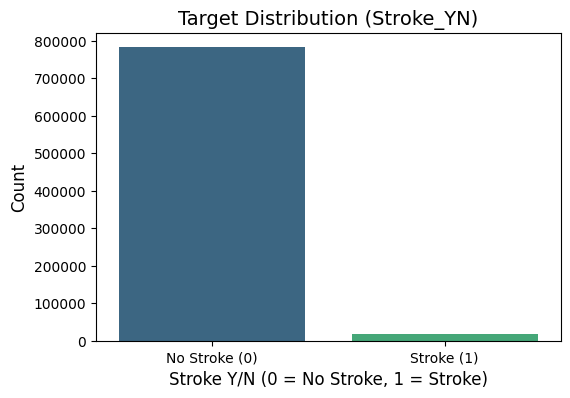

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution (Stroke_YN)", fontsize=14)
plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
plt.show()

# Data Class

In [81]:
import torch
from torch.utils.data import Dataset

class ECGDataset(Dataset):
    def __init__(self, memmap, labels_df):
        self.df = labels_df
        self.memmap = memmap

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      # Access data directly from the DataFrame
      start = self.df.loc[idx, 'start']
      length = self.df.loc[idx, 'length']
      # file_idx = self.df.loc[idx, 'file_idx'] # You might not need file_idx here anymore

      # Extract the flat signal slice
      signal = self.memmap[start : start + length * 12]  # 12 features per timestep
      signal = (signal - signal.mean(axis=0)) / (signal.std(axis=0) + 1e-6)

      # Reshape to [length, 12]
      signal = signal.reshape(length, 12)

      # Convert signal to PyTorch tensor before checking for NaN/inf
      signal = torch.tensor(signal, dtype=torch.float32)

      if torch.isnan(signal).any() or torch.isinf(signal).any():
        return None

      label = self.df.loc[idx, 'Stroke_YN']  # Access label from DataFrame
      return signal, torch.tensor(label, dtype=torch.long) # signal is already a tensor


In [82]:
from torch.nn.utils.rnn import pad_sequence
def safe_collate(batch):
    # Filter out None entries
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # Skip entire batch if empty (optional, or raise Exception)

    signals, labels = zip(*batch)
    signals = pad_sequence(signals, batch_first=True)  # if variable-length ECG
    labels = torch.tensor(labels)
    return signals, labels


In [83]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class ECGDataModule(pl.LightningDataModule):
    def __init__(self, memmap, train_df, val_df, test_df, batch_size=32):
        super().__init__()
        self.memmap = memmap
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ECGDataset(self.memmap, self.train_df)
        self.val_dataset = ECGDataset(self.memmap, self.val_df)
        self.test_dataset = ECGDataset(self.memmap, self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=11, collate_fn=safe_collate, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,  num_workers=11, collate_fn=safe_collate, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=11, collate_fn=safe_collate, pin_memory=True)


# Simple LSTM Model

In [84]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.classification import BinaryF1Score, BinaryAUROC


class LSTMSleepClassifier(pl.LightningModule):
    def __init__(self, input_size=12, hidden_size=64, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()

        self.train_auc = BinaryAUROC()
        self.val_auc = BinaryAUROC()
        self.test_auc = BinaryAUROC()

        self.fc = nn.Linear(hidden_size * 2, 1)  # bidirectional
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(self.device))

    def forward(self, x):
        # x: (B, T, C) → needs to be (B, T, 12)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        logits = self.fc(out)
        return logits.squeeze()

    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())
        acc = (preds == y).float().mean()
        f1 = self.train_f1(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_f1", f1, prog_bar=True)
        self.log("train_auc", auc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())
        acc = (preds == y).float().mean()
        f1 = self.val_f1(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)

        return loss


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())

        acc = (preds == y).float().mean()
        f1 = self.test_f1(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_auc", auc, prog_bar=True)

        return loss

    # def configure_gradient_clipping(
    #     self,
    #     optimizer=None,
    #     optimizer_idx=None,
    #     gradient_clip_val=None,
    #     gradient_clip_algorithm=None
    # ):
    #     if optimizer is not None:
    #         torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)



    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)  # Reduced lr


# Data Sampling

In [85]:
import pandas as pd
import numpy as np

memmap_data = np.memmap(memmap_path, dtype=np.float32, mode='r')
# memmap_data = torch.tensor(memmap_data).to("cuda")
meta = np.load(memmap_meta_path, allow_pickle=True)
start = meta['start']
length = meta['length']

# Load labels CSV
df = df_labels.copy()

# Sanity check
assert len(df) == len(start), "Mismatch between label and memmap metadata length"

# Add metadata into DataFrame
df['start'] = start
df['length'] = length

# Now you can split the DataFrame while keeping track of ECG data pointers
from sklearn.model_selection import train_test_split

# Split test set with preserved stroke ratio
train_val_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df['Stroke_YN'], random_state=42
)

# Then split stroke/non-stroke from train_val_df as discussed before
stroke_df = train_val_df[train_val_df['Stroke_YN'] == 1]
nonstroke_df = train_val_df[train_val_df['Stroke_YN'] == 0]

# Balanced sampling
train_stroke, val_stroke = train_test_split(stroke_df, test_size=0.1, random_state=42)
train_nonstroke = nonstroke_df.sample(n=len(train_stroke)*2, random_state=42)
val_nonstroke = nonstroke_df.drop(train_nonstroke.index).sample(n=len(val_stroke)*2, random_state=42)

# Final splits
train_df = pd.concat([train_stroke, train_nonstroke]).reset_index(drop=True)
val_df = pd.concat([val_stroke, val_nonstroke]).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [87]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_df["Stroke_YN"].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels)

# class_weights[1] is the weight for positive class
pos_weight = class_weights[1] / class_weights[0]  # Convert to ratio


Model and data Initialization

In [88]:
# Create the data module
ecg_dm = ECGDataModule(
    memmap=memmap_data,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=64
)

In [89]:
# Initialize model
model = LSTMSleepClassifier(input_size=12)

# Setting up Mlflow for model baseline tracking

# Model Training

In [90]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
import mlflow

import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "af7c8365aec4d3ff7a40563a35ec94d4bc9b4512"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"
# Setup
experiment_name = "lstm-ecg"
tracking_uri = f"https://dagshub.com/{os.environ['MLFLOW_TRACKING_USERNAME']}/{os.environ['MLFLOW_TRACKING_PROJECTNAME']}.mlflow"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking experiment name: {experiment_name}")
print(f"Tracking URI: {tracking_uri}")

# Use same URI in logger
mlf_logger = MLFlowLogger(
    experiment_name=experiment_name,
    tracking_uri=tracking_uri,
    log_model=True
)

2025/04/20 16:56:14 INFO mlflow.tracking.fluent: Experiment with name 'lstm-ecg' does not exist. Creating a new experiment.


MLflow tracking experiment name: lstm-ecg
Tracking URI: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


In [94]:
trainer = Trainer(logger=mlf_logger, max_epochs=5)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, datamodule=ecg_dm)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/.shortcut-targets-by-id/1rFfT7F_iTUUjh7EWzWgquzPn3Fzd6KTD/Colab Notebooks/ECG-MIMIC-main/1/1618d6bbaec44758be9d8ef5cee69b42/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | lstm      | LSTM              | 139 K  | train
1 | train_f1  | BinaryF1Score     | 0      | train
2 | val_f1    | BinaryF1Score     | 0      | train
3 | test_f1   | BinaryF1Score     | 0      | train
4 | train_auc | BinaryAUROC       | 0      | train
5 | val_auc   | BinaryAUROC       | 0      | train
6 | test_auc  | BinaryAUROC       | 0      | train
7 | fc        | Linear            | 129    | train
8 | loss_fn   | BCEWithLogitsLoss | 0      | train
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Evaluation Metrics